# Canis lupus meets Felis silvestris

This notebook should show the capabilities of GeoEngine. Therefore a few useful techniques will be shown: 
- Usage of the GBIF data catalog
- Point in Polygon selection
- Raster Vector Join of occurence data with land use classification
- Plotting of a class histogram
- Nested Workflows

It is recommended when building a own nested workflow to build it in multiple steps as seen in this notebook.

Documentation about the Operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

In [1]:
#Import packages
import geoengine as ge
import geoengine_openapi_client
from datetime import datetime
from geoengine.types import RasterBandDescriptor
import altair as alt

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
#Initialize GeoEngine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [3]:
#Get the GBIF DataProvider id (Useful to translate the DataProvider name into the respective id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

## Load Boundaries of Germany for later cutting GBIF occurence out (Optional)

This chapter is not needed and only shows that country boundaries are available

In [4]:
#Create workflow to request germany boundary
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

<Axes: >

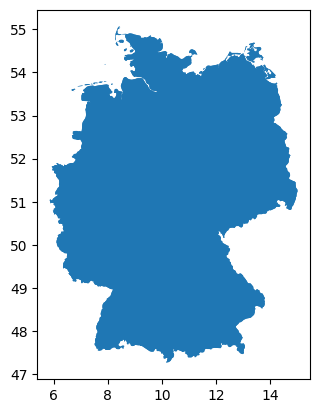

In [5]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

## Load Ökosystematlas for later Raster Vector Join with the occurence data (Optional)

This chapter is not needed and only shows that also raster data is available

In [6]:
#Create workflow to request the oekosystematlas raster data
workflow_oekosystematlas = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "oekosystematlas"
        }
    }
})

workflow_oekosystematlas

8a859eeb-0778-5190-a9d1-b1f787e4176d

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


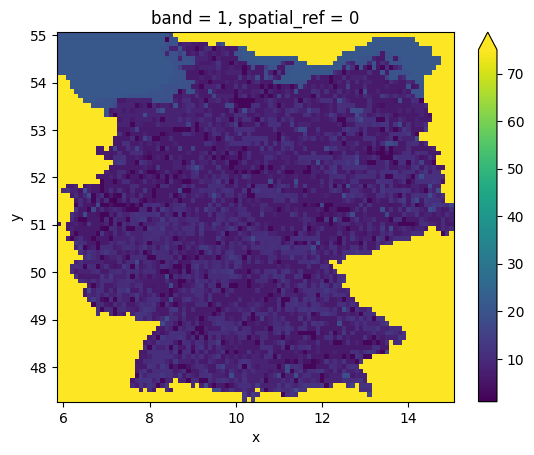

In [7]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a xarray dataarray
data = workflow_oekosystematlas.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmax=75)

## Processing Canis Lupus

Non of the following steps are in theory necessary as the whole workflow will be projected in the nested request in the end. The steps should show though the possibilities GeoEngine gives.

### Load Canis Lupus (Optional)

In [8]:
#Create workflow to request Canis lupus occurences
workflow_canis_lupus = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
        }
    }
})

workflow_canis_lupus.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  scientificname:
    Column Type: text
    Measurement: unitless
  basisofrecord:
    Column Type: text
    Measurement: unitless
  gbifid:
    Column Type: int
    Measurement: unitless

<Axes: >

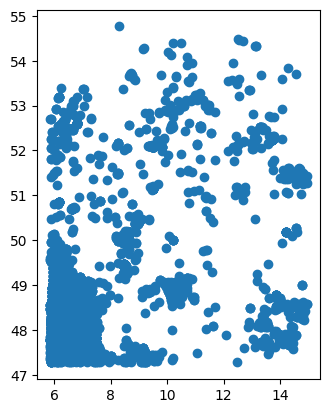

In [9]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_canis_lupus.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon Canis Lupus

In [10]:
#Create workflow to request Canis lupus occurences filtered by german boundary
workflow_canis_lupus_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Canis lupus ###############################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                    "attributeProjection": []
                } 
            }, #####################################################
            "polygons": { #Germany #################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ######################################################
        } 
    }
})

workflow_canis_lupus_cut

f30ac841-81b0-5301-bac6-840dd914c1ba

<Axes: >

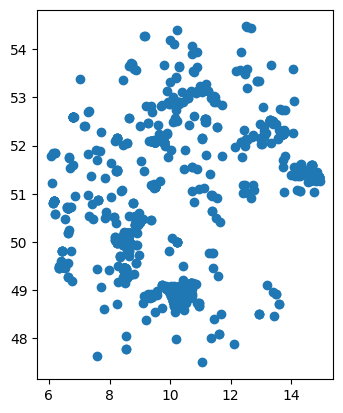

In [11]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data_canis_lupus = workflow_canis_lupus_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data
data_canis_lupus.plot()

### Nested Point in Polygon and Raster Vector Join Canis Lupus

In [12]:
#Create workflow to request Canis lupus occurences filtered by german boundary and joined with the Ökosystematlas data
workflow_canis_lupus_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": ["Ökosystematlas"],
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Canis lupus cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }] ##############################################################
        },
    }
})

workflow_canis_lupus_cut_join

89061dcb-c9ed-5561-8717-5f85d058c4a5

In [13]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_canis_lupus_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (8.53934 47.77785),HUMAN_OBSERVATION,3321351311,"Canis lupus Linnaeus, 1758",255.0,NaT,NaT
1,POINT (8.53934 47.77785),HUMAN_OBSERVATION,3321349309,"Canis lupus Linnaeus, 1758",255.0,NaT,NaT
2,POINT (11.20000 52.50000),HUMAN_OBSERVATION,3715659079,"Canis lupus Linnaeus, 1758",6.0,NaT,NaT
3,POINT (10.87370 48.72401),HUMAN_OBSERVATION,1338299215,"Canis familiaris Linnaeus, 1758",6.0,NaT,NaT
4,POINT (8.60464 49.28211),HUMAN_OBSERVATION,3389491416,"Canis familiaris Linnaeus, 1758",10.0,NaT,NaT
...,...,...,...,...,...,...,...
1384,POINT (14.66804 51.59264),HUMAN_OBSERVATION,1805909181,"Canis lupus Linnaeus, 1758",5.0,NaT,NaT
1385,POINT (8.84425 50.34940),HUMAN_OBSERVATION,3389448708,"Canis familiaris Linnaeus, 1758",11.0,NaT,NaT
1386,POINT (9.49982 52.08340),HUMAN_OBSERVATION,3387802693,"Canis familiaris Linnaeus, 1758",12.0,NaT,NaT
1387,POINT (14.20000 51.45000),HUMAN_OBSERVATION,2841271710,"Canis lupus Linnaeus, 1758",5.0,NaT,NaT


It can be seen that the variable 'Ökosystematlas' is numerical, while the classes are human-readably coded in the files metadata. This can be adapted using a Class Histogram

## Nested Full Workflow Canis Lupus

In [14]:
#Create workflow to plot Canis lupus occurences filtered by german boundary and joined with the Ökosystematlas data as a class histogram
workflow_canis_lupus_full = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": { #Canis lupus cut join #####################################
                "type": "RasterVectorJoin",
                "params": {
                        "names": ["Ökosystematlas"],
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    }]
                }
            } ######################################################################
       }
    }
})
    
workflow_canis_lupus_full

7fe94a60-24d1-5618-83ad-e91068961ffe

In [15]:
#Request the plot from Geoengine
plot_canis_lupus = workflow_canis_lupus_full.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_canis_lupus.spec)

alt.Chart(...)

## Processing Felis silvestris

Non of the following steps are in theory necessary as the whole workflow will be projected in the nested request in the end. The steps should show though the possibilities GeoEngine gives.

### Load felis silvestris (Optional)

In [16]:
#Create workflow to request Felis silvestris occurences
workflow_felis_silvestris = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
        }
    }
})

workflow_felis_silvestris

f8d5abd5-7d5f-567e-97a2-7830052d6cbf

<Axes: >

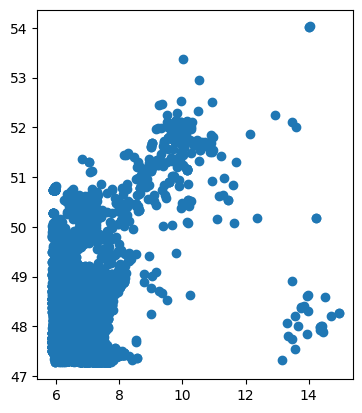

In [17]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_felis_silvestris.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon Felis silvestris

In [18]:
#Create workflow to request Felis silvestris occurences filtered by german boundary
workflow_felis_silvestris_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Felis silvestris ################################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                    "attributeProjection": []
                }
            }, ###########################################################
            "polygons": { #Germany #######################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ############################################################
        } 
    }
})

workflow_felis_silvestris_cut

518c27b3-0ce7-56ac-b826-5a72be463a73

<Axes: >

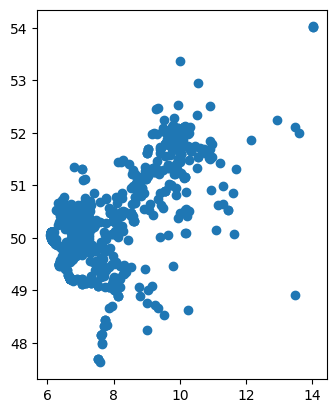

In [19]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data_felis_silvestris = workflow_felis_silvestris_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data
data_felis_silvestris.plot()

### Nested Point in Polygon and Raster Vector Join Canis Lupus

In [20]:
#Create workflow to request Felis silvestris occurences filtered by german boundary and joined with the Ökosystematlas data
workflow_felis_silvestris_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": ["Ökosystematlas"],
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Felis silvestris cut #####################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ###################################################################
            "rasters": [{ #Ökosystematlas ########################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }] ###################################################################
        },
    }
})

workflow_felis_silvestris_cut_join

7886eb1c-a8bd-5c94-adba-1913e0a0420c

In [21]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_felis_silvestris_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (11.31000 50.98000),FOSSIL_SPECIMEN,1698406915,"Felis silvestris Schreber, 1777",8.0,NaT,NaT
1,POINT (6.83344 50.37565),HUMAN_OBSERVATION,2835215533,"Felis silvestris Schreber, 1777",8.0,NaT,NaT
2,POINT (10.05000 52.00000),HUMAN_OBSERVATION,2838120499,Felis silvestris silvestris,5.0,NaT,NaT
3,POINT (9.90141 51.85110),HUMAN_OBSERVATION,3705535804,"Felis silvestris Schreber, 1777",11.0,NaT,NaT
4,POINT (7.59997 50.67584),HUMAN_OBSERVATION,3455430609,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
...,...,...,...,...,...,...,...
1167,POINT (9.77408 52.10230),HUMAN_OBSERVATION,1338683724,"Felis silvestris Schreber, 1777",12.0,NaT,NaT
1168,POINT (7.13802 50.53525),HUMAN_OBSERVATION,1677121729,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
1169,POINT (8.65372 51.20421),HUMAN_OBSERVATION,1944809239,"Felis silvestris Schreber, 1777",8.0,NaT,NaT
1170,POINT (7.77909 49.75637),HUMAN_OBSERVATION,3388281740,"Felis silvestris Schreber, 1777",8.0,NaT,NaT


## Nested Full Workflow Felis silvestris

In [22]:
#Create workflow to plot Felis silvestris occurences filtered by german boundary and joined with the Ökosystematlas data as a class histogram
workflow_felis_silvestris_full = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": {
                "type": "RasterVectorJoin",
                "params": {
                        "names": ["Ökosystematlas"],
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    }]
                }
            }
       }
    }
})
    
workflow_felis_silvestris_full

00845838-40ce-5435-83fc-45de14d6bb53

In [23]:
#Request the plot from Geoengine
plot_felis_silvestris = workflow_felis_silvestris_full.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_felis_silvestris.spec)

alt.Chart(...)

# Comparison Canis lupus and Felis silvestris

In [24]:
#Show the plot from Canis lupus
alt.Chart.from_dict(plot_canis_lupus.spec)

alt.Chart(...)

In [25]:
#Show the plot from Felis silvestris
alt.Chart.from_dict(plot_felis_silvestris.spec)

alt.Chart(...)

# Further experiments

In this chapter some further useful uses between geoengine and python are shown

In [26]:
#Comparison plots
import pandas as pd

# Convert the JSON data to pandas DataFrames
df1 = pd.DataFrame(plot_canis_lupus.spec['data']['values'])
df2 = pd.DataFrame(plot_felis_silvestris.spec['data']['values'])

df1['dataset'] = 'Canis lupus'
df2['dataset'] = 'Felis silvestris'

combined_df = pd.concat([df1, df2])

chart = alt.Chart(combined_df).mark_bar().encode(
    x=alt.X('Land Cover:N', title='Land Cover'),
    y=alt.Y('Frequency:Q', title='Frequency'),
    color=alt.Color('dataset:N', title='Dataset'),
    xOffset=alt.Color('dataset:N', title='Dataset')
).properties(width=600)

# Display the grouped barplot
chart

alt.Chart(...)

<Axes: >

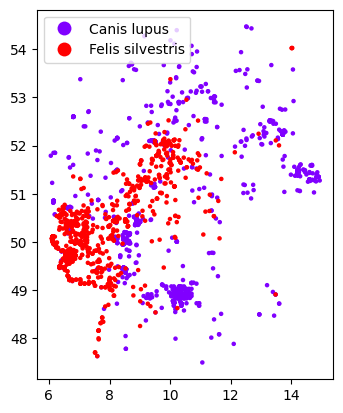

In [27]:
#Plotting of multiple species
import geopandas as gpd

gdf1 = data_canis_lupus
gdf2 = data_felis_silvestris

gdf1['dataset'] = 'Canis lupus'
gdf2['dataset'] = 'Felis silvestris'

combined_gdf = pd.concat([gdf1, gdf2])

combined_gdf.plot(column='dataset', cmap='rainbow', markersize=5, legend=True)